# Generate Approximate Molecular Coordinates
A key limitation of some of our ML models is that they require the B3LYP-relaxed atomic coordinates to predict molecular energies. To see if the coordiantes are a strict requirement, we explore generating coordinates using OpenBabel and using those as input into the model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from pybel import Molecule, readstring
from tqdm import tqdm_notebook as tqdm
from openbabel import OBForceField
import numpy as np
import pybel

In [2]:
_, test_data = load_benchmark_data()

## Generate Molecules from SMILES Strings
We are going to take the smiles string of the relaxed molecules `smiles_1` so that the generated structure nominally matches up chemically with the XYZ coordiantes. The SMILES before and after relaxation _should_ be the same.

Generate the molecules

In [3]:
%%time
test_data['mol'] = test_data['smiles_1'].apply(lambda x: readstring('smi', x))

CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.86 s


## Generate Atomic Coordinates
We do just a basic generation of molecular coordinates. No rotor testing or further relaxation, etc.

Start off with making a first stab at the coordinates

In [4]:
%%time
for mol in tqdm(test_data['mol']):
    mol.make3D()

Save the XYZ coordinates

In [5]:
test_data['xyz_gen'] = test_data['mol'].apply(lambda x: x.write('xyz'))

Measure the RMSD from the B3LYP coordinates

In [6]:
def get_rmsd(data, ref_col, match_col):
    """Generate the RMSD between each molecule
    
    Args:
        data (DataFrame): Dataset to evaluate
        ref_col (string): Name of column with the reference structure (in xyz format)
        match_col (string): Name of column with the approximate structure
    Return:
        (ndarray) RMSD between each pair of molecules
    """
    
    results = []
    for xyz_a, xyz_b in tqdm(data[[ref_col, match_col]].values):
        # Make the tool to match the molecules
        align = pybel.ob.OBAlign()
        align.SetRefMol(readstring("xyz", xyz_a).OBMol)
        align.SetTargetMol(readstring("xyz", xyz_b).OBMol)
        
        # Perform the alignment
        align.Align()
        results.append(align.GetRMSD())
        
    return results

In [7]:
%%time
test_data['rmsd_gen'] = get_rmsd(test_data, 'xyz', 'xyz_gen')


CPU times: user 9.84 s, sys: 281 ms, total: 10.1 s
Wall time: 10.8 s


## Refine the Coordinates
Relax the coordinates with a forcefield

In [8]:
%%time
for mol in tqdm(test_data['mol']):
    mol.localopt()

Save the XYZ coordinates

In [9]:
test_data['xyz_relaxed'] = test_data['mol'].apply(lambda x: x.write('xyz'))

Measure the RMSD from the B3LYP coordinates

In [10]:
test_data['rmsd_relaxed'] = get_rmsd(test_data, 'xyz', 'xyz_relaxed')

## Do a Rotor Search
Attempt to find better coordinates through a rotor search

In [11]:
def globalopt(mol):
    """Attempt to further refine the molecular structure through a rotor search
    
    Code adapted from: http://forums.openbabel.org/OpenBabel-Conformer-Search-td4177357.html
    
    Args:
        mol (Molecule): Molecule to be optimized
    Returns:
        (bool): Whether the optimization was performed
    """
    
    # Try to get a forcefield that works with this molecule
    ff = pybel._forcefields["mmff94"]
    success = ff.Setup(mol.OBMol)
    if not success:
        ff = pybel._forcefields["uff"]
        success = ff.Setup(mol.OBMol)
        if not success:
            return False
   
    # initial cleanup before the weighted search
    ff.SteepestDescent(500, 1.0e-4)
    ff.WeightedRotorSearch(100, 20)
    ff.ConjugateGradients(500, 1.0e-6)
    ff.GetCoordinates(mol.OBMol) 

In [12]:
%%time
for mol in tqdm(test_data['mol']):
    globalopt(mol)

Save the XYZ coordinates

In [13]:
test_data['xyz_searched'] = test_data['mol'].apply(lambda x: x.write('xyz'))

Measure the RMSD from the B3LYP coordinates

In [14]:
test_data['rmsd_searched'] = get_rmsd(test_data, 'xyz', 'xyz_searched')

## Plot the RMSD for Each Inferred Molecular Structure
See how good each approximation is

In [15]:
test_data[[x for x in test_data.columns if x.startswith('rmsd_')]].describe()

,rmsd_gen,rmsd_relaxed,rmsd_searched
count,13026.000000,13026.000000,13026.000000
mean,0.534430,0.478543,0.484822
std,0.366216,0.395479,0.411835
min,0.003977,0.003908,0.003908
25%,0.231432,0.119886,0.103078
50%,0.509025,0.432808,0.448677
75%,0.736801,0.699449,0.725200
max,3.364095,3.346377,3.036443


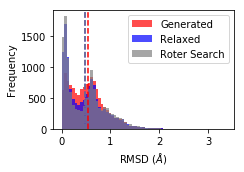

In [16]:
fig, ax = plt.subplots()

# Get the plot range
max_rmsd = test_data[['rmsd_relaxed', 'rmsd_gen']].max().max()
bins = np.linspace(0, max_rmsd, 64)

# Plot the histograms
ax.hist(test_data['rmsd_gen'], bins, label='Generated', alpha=0.7, color='r')
ax.hist(test_data['rmsd_relaxed'], bins, label='Relaxed', alpha=0.7, color='b')
ax.hist(test_data['rmsd_searched'], bins, label='Roter Search', alpha=0.7, color='gray')

# Plot the means
ax.set_ylim(ax.get_ylim())
ax.plot([test_data['rmsd_gen'].mean()]*2, ax.get_ylim(), '--', color='r')
ax.plot([test_data['rmsd_relaxed'].mean()]*2, ax.get_ylim(), '--', color='b')
ax.plot([test_data['rmsd_searched'].mean()]*2,  ax.get_ylim(), '--', color='gray')


ax.set_xlabel('RMSD ($\AA$)')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2.5)
ax.legend()
fig.tight_layout()

## Save the Data to Disk
We no longer the the OpenBabel molecule, so we'll drop that before saving

In [17]:
test_data.drop(['mol'], 'columns').to_pickle('test_data.pkl.gz')